# 1. Library prep

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import eda

# NLP stuff
# TODO: remove unnecessary imports
from nltk import ngrams, pos_tag
from nltk.corpus import names, stopwords, wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, RegexpTokenizer, MWETokenizer
from nltk.cluster import cosine_distance, euclidean_distance
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.chunk import ne_chunk

# other string processing
import re
import string

# classifiers
from sklearn.ensemble import RandomForestClassifier, BaseEnsemble
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration

# model selection and metric helpers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, fbeta_score, log_loss, roc_auc_score, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

Run this if NLTK hasn't been set up locally

In [2]:
#import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# 2. Data loading and initial inspection

From the README:

- Column 1: the ID of the statement ([ID].json).
- Column 2: the label.
- Column 3: the statement.
- Column 4: the subject(s).
- Column 5: the speaker.
- Column 6: the speaker's job title.
- Column 7: the state info.
- Column 8: the party affiliation.
- Column 9-13: the total credit history count, including the current statement.
  - 9: barely true counts.
  - 10: false counts.
  - 11: half true counts.
  - 12: mostly true counts.
  - 13: pants on fire counts.
- Column 14: the context (venue / location of the speech or statement).

In [3]:
# read the LIAR dataset

liar_credit_hist_headers = ['speaker_bt', 'speaker_f', 'speaker_ht', 'speaker_mt', 'speaker_pof']
liar_speaker_headers = ['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation'] + liar_credit_hist_headers
liar_column_headers = ['id', 'label', 'statement', 'subjects']  + liar_speaker_headers + ['context']

# read the pre-prepared training, validation and test sets

liar_train = pd.read_csv("./data/liar_dataset/train.tsv", sep='\t', names=liar_column_headers)
liar_valid = pd.read_csv("./data/liar_dataset/valid.tsv", sep='\t', names=liar_column_headers)
liar_test = pd.read_csv("./data/liar_dataset/test.tsv", sep='\t', names=liar_column_headers)

# combine the pre-prepared training and validation sets; we want to do our own 5-fold cv

liar_train = liar_train.append(liar_valid)

liar_train

,id,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
1280,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
1281,401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad
1282,1055.json,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.


In [4]:
liar_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11524 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11524 non-null  object 
 1   label                11524 non-null  object 
 2   statement            11524 non-null  object 
 3   subjects             11522 non-null  object 
 4   speaker              11522 non-null  object 
 5   speaker_job          8282 non-null   object 
 6   speaker_us_state     9037 non-null   object 
 7   speaker_affiliation  11522 non-null  object 
 8   speaker_bt           11522 non-null  float64
 9   speaker_f            11522 non-null  float64
 10  speaker_ht           11522 non-null  float64
 11  speaker_mt           11522 non-null  float64
 12  speaker_pof          11522 non-null  float64
 13  context              11410 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.3+ MB


In [5]:
liar_train.iloc[0]['statement']

'Says the Annies List political group supports third-trimester abortions on demand.'

Plot the truth values of the dataset

In [8]:
liar_label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-on-fire']

def liar_truthdist_subj(subj=None, ax=None, saveplot=True, longtitle=True):
    """
    Plots the truth distribution of the LIAR dataset, optionally by subject
    Return the dataframe representing the plot
    """   
    if not ax:
        fig, ax = plt.subplots()

    if subj == None:
        subj_filter = liar_train['subjects'].apply(lambda x: True)
        plt_title = 'distribution of truth values'
        filename = './image/liar_truthvals_dist.png'
    else:
        subj_filter = liar_train['subject_list'].apply(lambda entry: subj in entry)
        if longtitle:
            plt_title = '"' + subj + '": distribution of truth values'
        else:
            plt_title = subj
        filename = './image/liar_truthvals_dist_' + subj + '.png'
    
    subj_truthdist = pd.DataFrame({'label': liar_label, 'count': label_count} for liar_label, label_count in zip(liar_label_order, liar_train[subj_filter]['label'].value_counts()))
    
    sns.barplot(data=subj_truthdist, y='label', x='count', palette='coolwarm', ax=ax).set(title=plt_title, xlabel='count')
    plt.tight_layout()

    if saveplot:
        plt.savefig(filename)

    return subj_truthdist, ax

(           label  count
 0           true   2362
 1    mostly-true   2258
 2      half-true   2213
 3    barely-true   1891
 4          false   1845
 5  pants-on-fire    955,
 <matplotlib.axes._subplots.AxesSubplot at 0x210129ed148>)

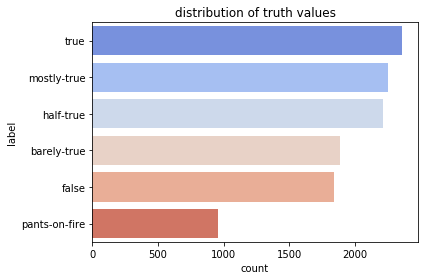

In [9]:
liar_truthdist_subj()

In [10]:
liar_train['speaker_affiliation'].value_counts()

republican                      5094
democrat                        3731
none                            1967
organization                     237
independent                      166
newsmaker                         63
libertarian                       46
activist                          43
journalist                        40
columnist                         37
talk-show-host                    29
state-official                    20
labor-leader                      15
business-leader                   10
tea-party-member                  10
green                              3
education-official                 3
constitution-party                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
county-commissioner                1
ocean-state-tea-party-action       1
Name: speaker_affiliation, dtype: int64

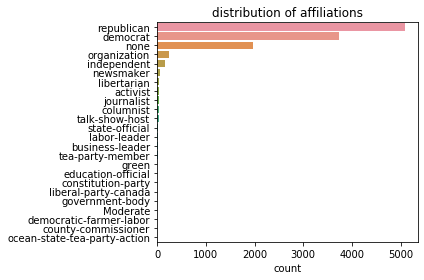

In [11]:
sns.barplot(y=liar_train['speaker_affiliation'].value_counts().index, x=liar_train['speaker_affiliation'].value_counts()).set(title='distribution of affiliations', xlabel='count')
plt.tight_layout()
plt.savefig('./image/liar_affiliations_dist.png');

In [12]:
liar_speakers_full = liar_train[liar_speaker_headers]

liar_speakers = liar_speakers_full.drop_duplicates().sort_values(by='speaker')
#liar_speakers['count_in_set'] = liar_speakers_full.groupby(liar_speaker_headers, as_index=False).size().values

liar_speakers['speaker'].value_counts()

#liar_speakers_full.groupby('speaker', as_index=False).size()

robert-puente                  2
kasim-reed                     2
danny-tarkanian                2
nh-afl-cio                     1
mark-schlereth                 1
                              ..
oregon-business-association    1
philadelphia-daily-news        1
new-approach-oregon            1
emilys-list                    1
critics-water-fluoridation     1
Name: speaker, Length: 3126, dtype: int64

Inconsistencies are due to the merging of the default train and validation sets

In [13]:
liar_train[liar_train['speaker']=='kasim-reed']

,id,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
559,4659.json,true,On letting Occupy Atlanta protesters stay in W...,"occupy-wall-street,public-safety",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,statements to the public
1587,7862.json,mostly-true,My office is about a 300-step walk to the gove...,"city-government,economy",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,leadership forum
1901,9749.json,true,The minimum number of infrastructure (needs) i...,city-government,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference
2073,8186.json,true,State law says that once the state appraises a...,"city-government,corrections-and-updates,sports",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,an interview
3233,8898.json,mostly-true,"Right now, we only keep 50 percent of Georgia ...","economy,education,jobs",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
3483,8171.json,mostly-true,"Atlanta now has as many visitors as Las Vegas,...",tourism,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a radio interview
4279,8938.json,true,The annual gross domestic product of metro Atl...,economy,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
4291,7228.json,false,On same-sex marriage,"civil-rights,gays-and-lesbians,marriage",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,NaN
5002,6038.json,pants-fire,The new Hartsfield-Jackson international termi...,transportation,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference
5410,5252.json,half-true,We have cut crime across every single zone in ...,crime,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,the State of the City address


We don't need the counts for individual speaker truth values, especially when there's no date attached

TODO: pull from main API to extract date of news?

Need to convert subjects column into a list

In [14]:
liar_train['subject_list'] = liar_train['subjects'].apply(lambda s: str(s).split(','))
liar_test['subject_list'] = liar_test['subjects'].apply(lambda s: str(s).split(','))

liar_train_subj_dummies = eda.createdummy_from_listentries(liar_train, 'subject_list')

liar_train_subj_dummies

,Alcohol,abc-news-week,abortion,afghanistan,after-the-fact,agriculture,animals,autism,bankruptcy,baseball,...,unions,urban,veterans,voting-record,water,wealth,weather,welfare,women,workers
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
LIAR_SUBJ_THRESHOLD = 200

liar_train_subj_summary = pd.DataFrame(data=liar_train_subj_dummies.sum(), 
                                       columns=['count']).sort_values(by='count', 
                                                                      ascending=False)
liar_train_subj_summary['is_minor'] = liar_train_subj_summary['count'] < LIAR_SUBJ_THRESHOLD

liar_train_subj_summary

,count,is_minor
economy,1009,False
health-care,854,False
candidates-biography,663,False
education,625,False
elections,471,False
...,...,...
wealth,2,True
urban,1,True
death-penalty,1,True
homeless,1,True


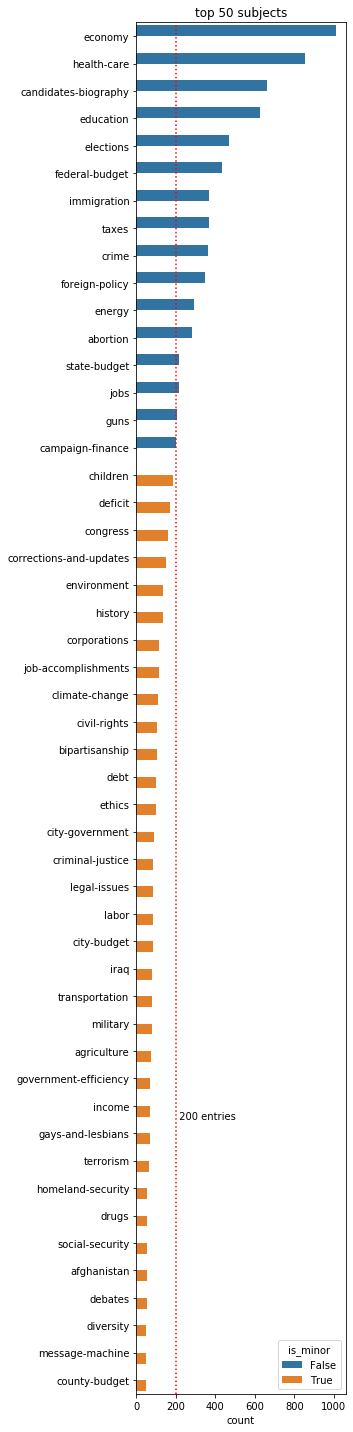

In [217]:
LIAR_SUBJ_COUNT_PLOTTED = 100

fig, ax = plt.subplots(figsize=(5,20))

sns.barplot(x=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['count'], y=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED).index, ax=ax, hue=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['is_minor']).set(title='top ' + str(LIAR_SUBJ_COUNT_PLOTTED) + ' subjects')
plt.axvline(LIAR_SUBJ_THRESHOLD, color='red', linestyle=':')
plt.text(LIAR_SUBJ_THRESHOLD, 0.2, " " + str(LIAR_SUBJ_THRESHOLD) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout()
plt.savefig('./image/liar_subj_dist_top100.png');

(           label  count
 0           true     11
 1    mostly-true      7
 2      half-true      6
 3    barely-true      5
 4          false      5
 5  pants-on-fire      3,
 <matplotlib.axes._subplots.AxesSubplot at 0x21015974488>)

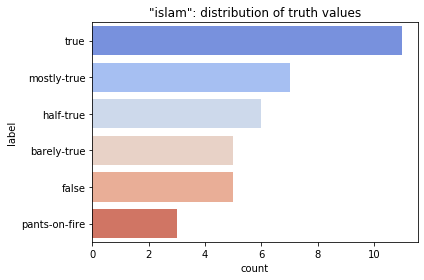

In [16]:
liar_truthdist_subj('islam')

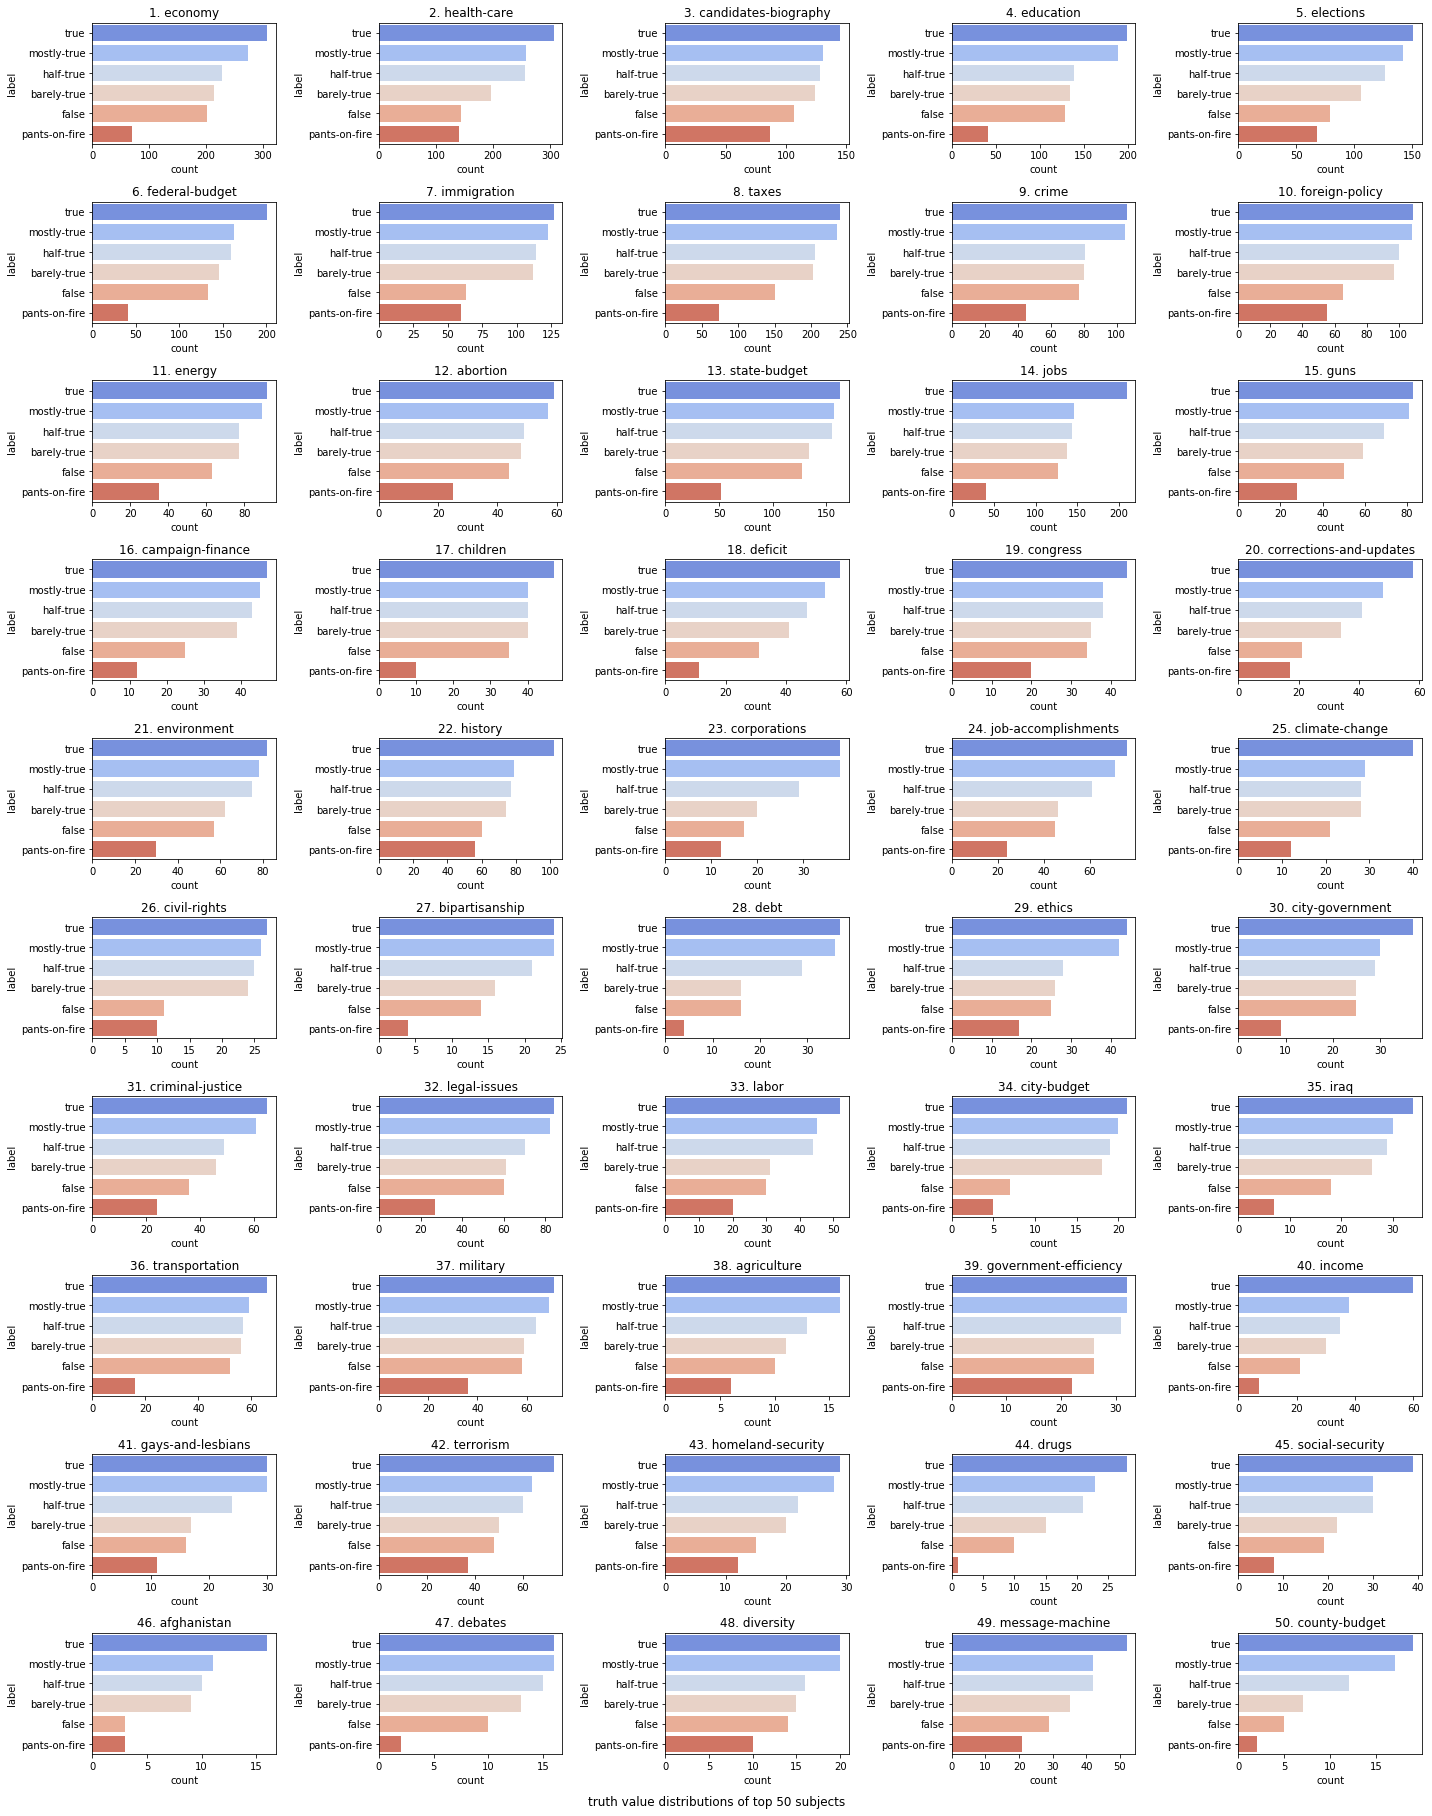

In [17]:
num_figs = 50
fig = plt.figure(figsize=(20,25))

for counter, subj in zip(range(0,num_figs), liar_train_subj_summary.index):
    ax = plt.subplot(10, 5, counter + 1)
    _ = liar_truthdist_subj(subj, ax=ax, saveplot=False)
    ax.set(title=str(counter + 1) + ". " + subj)

fig.suptitle('truth value distributions of top ' + str(num_figs) + ' subjects').set_y(0)

plt.tight_layout()
plt.savefig('./image/liar_top50_truthvals_dist.png')

In [ ]:
for truth_value in liar_label_order:
    liar_train_subj_summary[truth_value] = pd.DataFrame(data=liar_train_subj_dummies.sum(), 
                                                        columns=['count'])

In [31]:
#print(liar_train['label'])
#print(sum('abortion' in subj_list for subj_list in liar_train['subject_list'][liar_train['label']=='true']))

liar_train_subj_dummies.join(liar_train['label'])

,Alcohol,abc-news-week,abortion,afghanistan,after-the-fact,agriculture,animals,autism,bankruptcy,baseball,...,urban,veterans,voting-record,water,wealth,weather,welfare,women,workers,label
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,false
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,barely-true
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,false
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,barely-true
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,half-true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,mostly-true
10236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mostly-true
10237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,half-true
10238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,false


# Classification w/o NLP

# NLP exploration